<a href="https://colab.research.google.com/github/IndudiniThennakoon/.github/blob/main/diabetes_risk_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
data = pd.read_csv('/content/GlobalWeatherRepository.csv')

In [ ]:
# preprocessing

In [5]:
print("Dataset Information:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())
print(f"\nNumber of rows: {len(data)}")
print(f"\nNumber of columns: {len(data.columns)}")
print("\nFirst few rows:")
print(data.head())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26002 entries, 0 to 26001
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       26002 non-null  object 
 1   location_name                 26002 non-null  object 
 2   latitude                      26002 non-null  float64
 3   longitude                     26002 non-null  float64
 4   timezone                      26002 non-null  object 
 5   last_updated_epoch            26002 non-null  int64  
 6   last_updated                  26002 non-null  object 
 7   temperature_celsius           26002 non-null  float64
 8   temperature_fahrenheit        26002 non-null  float64
 9   condition_text                26002 non-null  object 
 10  wind_mph                      26002 non-null  float64
 11  wind_kph                      26002 non-null  float64
 12  wind_degree                   26002 non

In [ ]:
# encoding

In [6]:
for col in data.columns:
    if data[col].dtype == 'object':
        print(f"Encoding column: {col}")
        encoder = LabelEncoder()
        data[col] = encoder.fit_transform(data[col])

Encoding column: country
Encoding column: location_name
Encoding column: timezone
Encoding column: last_updated
Encoding column: condition_text
Encoding column: wind_direction
Encoding column: sunrise
Encoding column: sunset
Encoding column: moonrise
Encoding column: moonset
Encoding column: moon_phase


In [ ]:
# feature selection and target (I will temperature as the target value )

In [7]:
X = data[['latitude', 'longitude', 'humidity', 'wind_mph', 'pressure_mb']].values
y = data['temperature_celsius'].values

In [ ]:
#outlier removal ussing IQR

In [8]:
Q1 = np.percentile(X, 25, axis=0)
Q3 = np.percentile(X, 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [9]:
mask = np.all((X >= lower_bound) & (X <= upper_bound), axis=1)
X_cleaned = X[mask]
y_cleaned = y[mask]

In [ ]:
# feature selection (RFE)

In [10]:
model = LinearRegression()
rfe = RFE(model, n_features_to_select=3)
X_selected = rfe.fit_transform(X_cleaned, y_cleaned)

In [ ]:
#scaling the data

In [11]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [12]:
X_scaled = scaler_X.fit_transform(X_selected)
y_scaled = scaler_y.fit_transform(y_cleaned.reshape(-1, 1))

In [ ]:
#data augmentation | adding slight noise

In [13]:
def augment_data(X, y, noise_factor=0.01):
    augmented_X = []
    augmented_y = []

    for i in range(len(X)):
        noisy_X = X[i] + noise_factor * np.random.randn(*X[i].shape)
        augmented_X.append(noisy_X)
        augmented_y.append(y[i])

    return np.array(augmented_X), np.array(augmented_y)

In [14]:
X_augmented, y_augmented = augment_data(X_scaled, y_scaled)

In [ ]:
#prepare data for time series

In [15]:
time_steps = 10

In [16]:
def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [17]:
X_sequences, y_sequences = create_sequences(X_augmented, y_augmented, time_steps)

In [ ]:
# split train and test

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

In [ ]:
#build the RNN

In [19]:
model = Sequential()
model.add(SimpleRNN(units=5, return_sequences=False, input_shape=(time_steps, X_train.shape[2]), kernel_regularizer=l2(0.05)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(25, activation='relu', kernel_regularizer=l2(0.05)))
model.add(Dropout(0.5))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#compile the model with a reduced learing rate

In [20]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

In [ ]:
#early stopping to prevent overfitting

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
#train the model

In [22]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.1593 - val_loss: 0.6825
Epoch 2/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.7997 - val_loss: 0.5486
Epoch 3/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.6000 - val_loss: 0.4438
Epoch 4/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4545 - val_loss: 0.3501
Epoch 5/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3487 - val_loss: 0.2710
Epoch 6/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2612 - val_loss: 0.2045
Epoch 7/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1964 - val_loss: 0.1511
Epoch 8/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1450 - val_loss: 0.1109
Epoch 9/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1074 - val_loss: 0.0809
Epoch 10/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0806 - val_loss: 0.0590
Epoch 11/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0594 - val_loss: 0.0442
Epoch 12/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step

In [23]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss (MSE): {loss}')

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155
Test Loss (MSE): 0.01591229811310768


In [ ]:
#prediction

In [24]:
y_pred_scaled = model.predict(X_test)

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [25]:
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

In [27]:
#calculate accuracy metrics

In [29]:
mae = mean_absolute_error(y_test_original, y_pred)
mse = mean_squared_error(y_test_original, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred)
print(r2)

-3.598771339774487e-05


In [31]:
range_y = np.max(y_test_original) - np.min(y_test_original)
normalized_mae = mae / range_y
accuracy = (1 - normalized_mae) * 100
print(accuracy)

90.35860716901605


In [32]:
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f'Accuracy: {accuracy:.2f}%')

Mean Absolute Error (MAE): 4.772489451337057
Mean Squared Error (MSE): 41.0568366316975
Root Mean Squared Error (RMSE): 6.407560895668296
R² Score: -3.598771339774487e-05
Accuracy: 90.36%


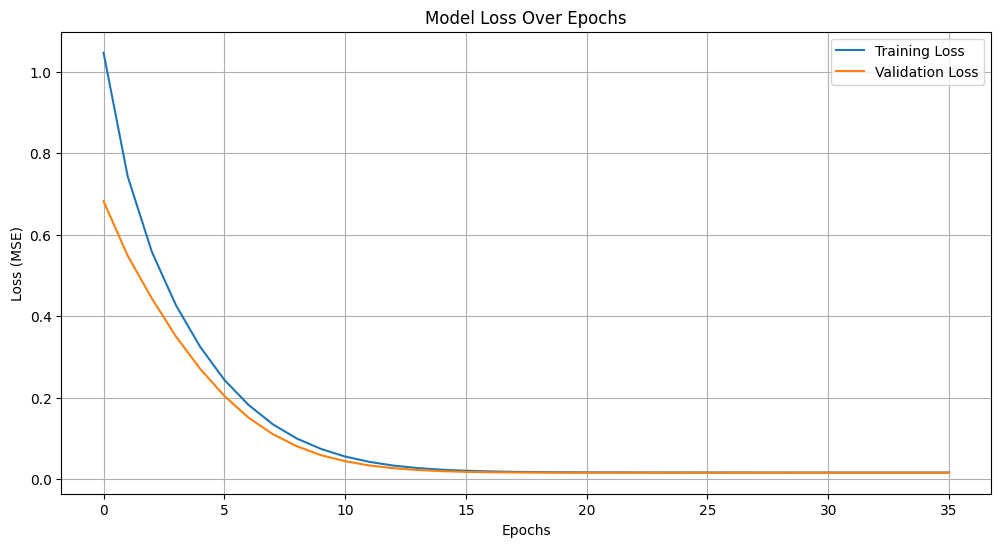

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()